## 합성곱 신경망을 활용한 엑스레이 영상 분류 모델

#### 데이터 다운로드 및 모듈 불러오기

In [ ]:
# 다운로드가 잘 되지 않을 경우 아래 명령어의 주석을 해제한 후 실행하고, 재시도해보세요.
#!pip install --upgrade --no-cache-dir gdown

In [1]:
!gdown 1M3Jf3QoxTVy8lDZ4Xb3d9gABu7xPew5A
!unzip chest_xray.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: chest_xray/train/PNEUMONIA/person504_bacteria_2127.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1486_bacteria_3881.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person459_bacteria_1956.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person23_bacteria_102.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1855_bacteria_4727.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person281_bacteria_1325.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person264_virus_547.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person39_bacteria_200.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person383_bacteria_1747.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person937_virus_1599.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person765_virus_1393.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person307_bacteria_1441.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person321_bacteria_1485.jpeg  
  inflating: chest_xray/train/PNEUMONIA/person1112_vi

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

base_dir = './chest_xray/'

In [3]:
# 하이퍼파라미터 설정
batch_size = 32
image_size = 224
learning_rate = 5e-4
epochs = 15
class_labels=['NORMAL', 'PNEUMONIA']

In [4]:
# 이미지 증강이 적용된 데이터 제네레이터 선언
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

test_datagen = ImageDataGenerator(
    rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary')

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


In [5]:
# 제네레이터 확인을 위한 이미지와 레이블 출력
def show_images(generator, num_images=5):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Normal' if labels[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.show()

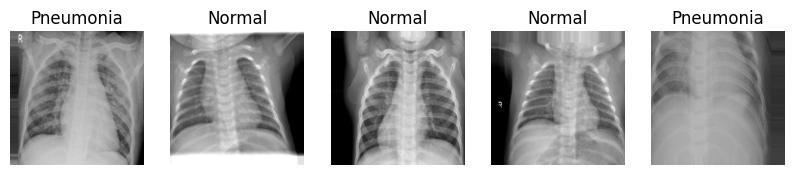

In [6]:
show_images(train_generator, num_images=5)

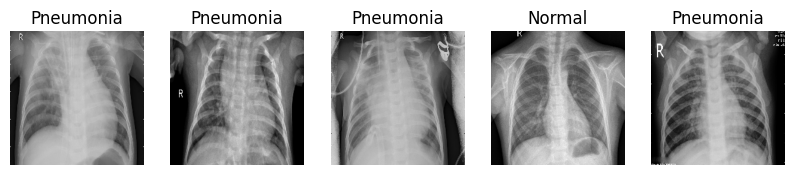

In [7]:
show_images(test_generator, num_images=5)

#### 모델 구현

In [8]:
# 모델 불러오기 및 선언
base_model = tf.keras.applications.ResNet50V2(input_shape=(image_size, image_size, 3),
                                              include_top=False,
                                              weights='imagenet',
                                              pooling='avg')

inputs = base_model.input
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(inputs, outputs)

94668760/94668760 [==============================] - 1s 0us/step


In [9]:
# 모델 컴파일링
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
callbacks = [ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.1, patience=2, min_lr=1e-7, verbose=1),
            ModelCheckpoint('checkpoint.tf', monitor='val_loss', mode='min', save_best_only=True)]

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#### 모델 학습

In [10]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/15
131/131 [==============================] - 161s 957ms/step - loss: 0.1669 - accuracy: 0.9348 - val_loss: 5.5727 - val_accuracy: 0.7191 - lr: 5.0000e-04
Epoch 2/15
131/131 [==============================] - 99s 756ms/step - loss: 0.1174 - accuracy: 0.9542 - val_loss: 6.9031 - val_accuracy: 0.2752 - lr: 5.0000e-04
Epoch 3/15
131/131 [==============================] - 120s 915ms/step - loss: 0.1062 - accuracy: 0.9629 - val_loss: 0.2687 - val_accuracy: 0.9291 - lr: 5.0000e-04
Epoch 4/15
131/131 [==============================] - 121s 918ms/step - loss: 0.0838 - accuracy: 0.9676 - val_loss: 0.1368 - val_accuracy: 0.9626 - lr: 5.0000e-04
Epoch 5/15
131/131 [==============================] - 100s 759ms/step - loss: 0.0664 - accuracy: 0.9760 - val_loss: 6.0879 - val_accuracy: 0.3298 - lr: 5.0000e-04
Epoch 6/15
131/131 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9712
Epoch 6: ReduceLROnPlateau reducing learning rate to 5.0000002374872565e-05.
131/131 [====

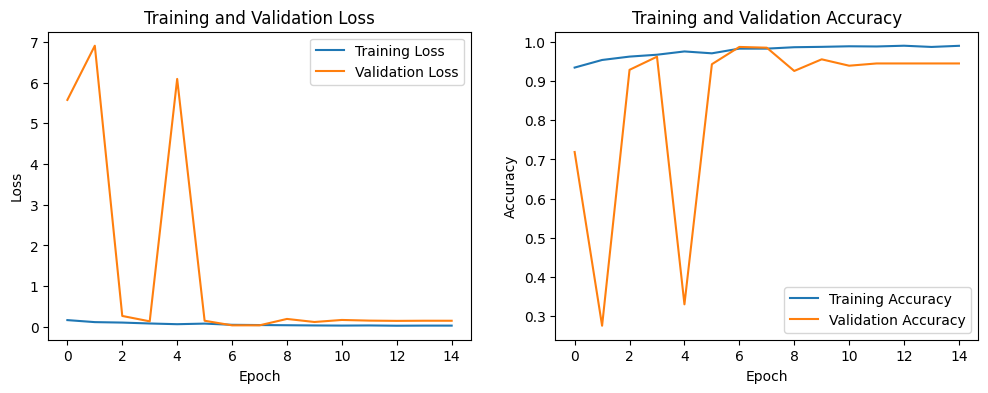

In [11]:
# 학습 로그 출력
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), history.history['loss'], label='Training Loss')
plt.plot(range(epochs), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(epochs), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [12]:
# 테스트 데이터를 바탕으로 평가
trained_model = tf.keras.models.load_model('checkpoint.tf')

trained_model.evaluate(test_generator)

20/20 [==============================] - 6s 255ms/step - loss: 0.8241 - accuracy: 0.7688


[0.8241114616394043, 0.768750011920929]

## 분류 작업에서의 다양한 평가 지표
#### Scikit-learn을 활용한 혼동 행렬과 평가지표 계산

In [13]:
# 혼동 행렬 시각화를 위한 함수 선언
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Ground truth')
    plt.xlabel('Prediction')

20/20 [==============================] - 7s 291ms/step


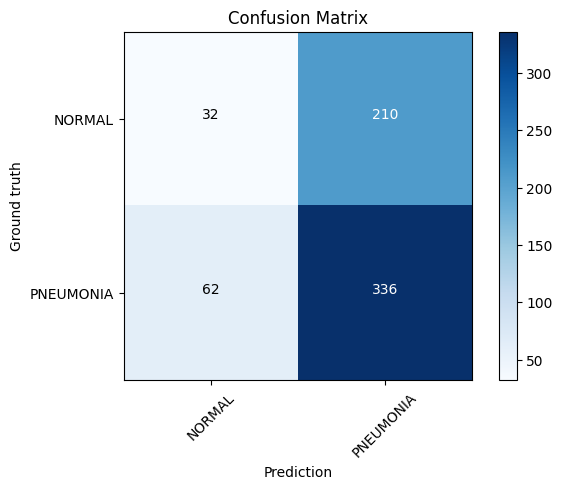

In [14]:
# 테스트 데이터를 바탕으로 혼동 행렬 계산
predictions = trained_model.predict(test_generator)
predicted_classes = (predictions > 0.5).astype('int').reshape(-1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
plot_confusion_matrix(conf_matrix, classes=class_labels, title='Confusion Matrix')
plt.show()

In [15]:
# 분류 레포트 생성 및 출력
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.34      0.13      0.19       242
   PNEUMONIA       0.62      0.84      0.71       398

    accuracy                           0.57       640
   macro avg       0.48      0.49      0.45       640
weighted avg       0.51      0.57      0.51       640



## 의료 인공지능과 설명 가능성

#### Grad-CAM을 구현하기 위한 함수 선언

In [16]:
import matplotlib.cm as cm

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_heatmap_on_image(heatmap, img):
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * 0.005 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img

<ipython-input-16-4d354680c0ee>:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


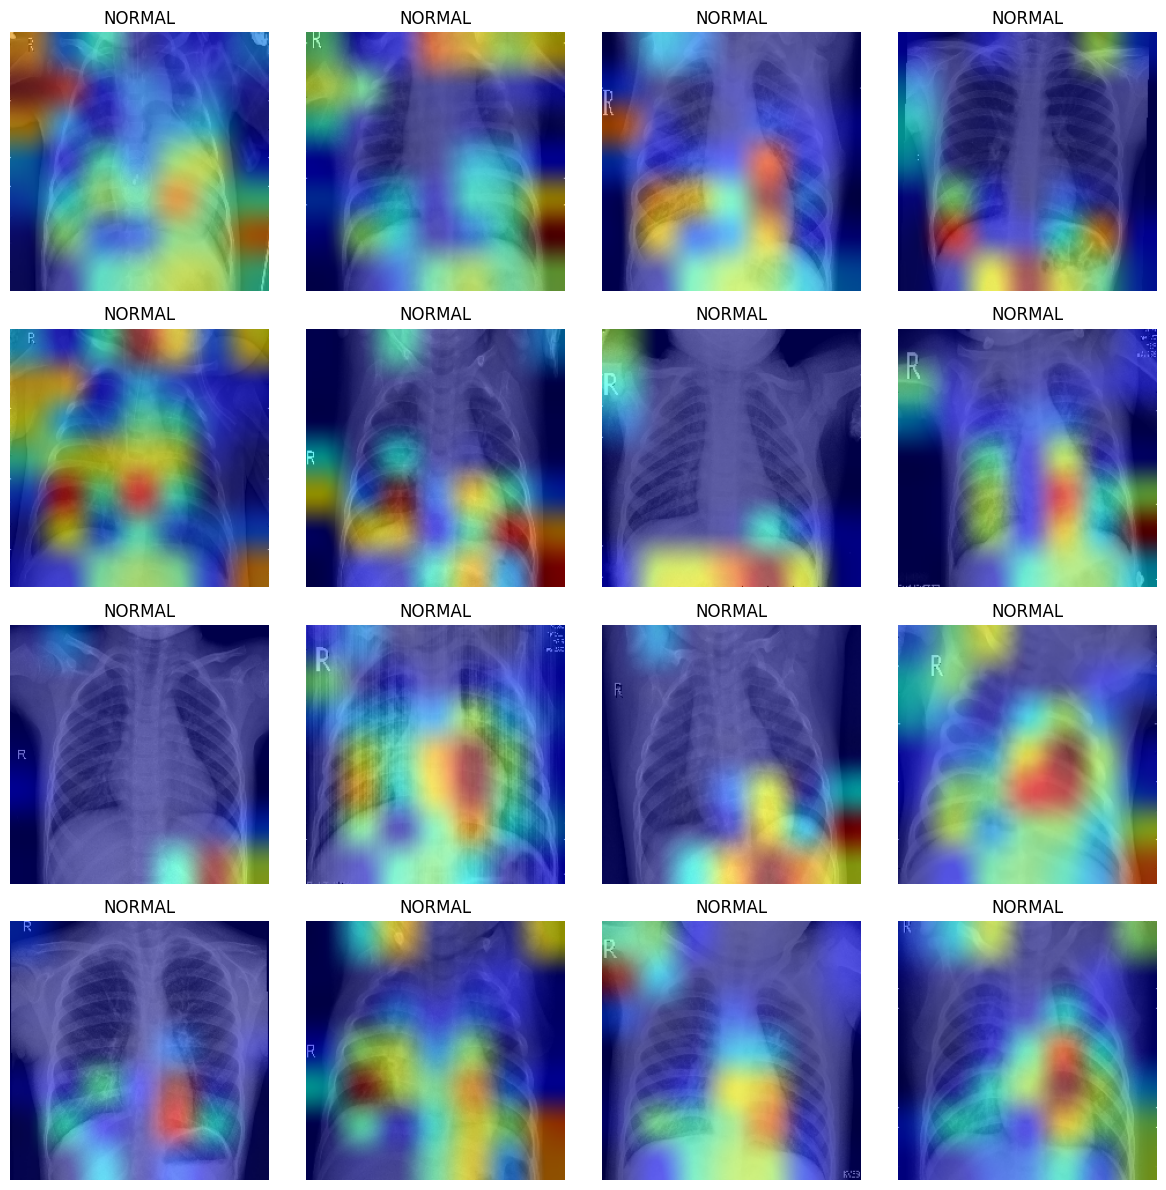

In [17]:
# Grad-CAM을 활용한 결과 시각화
last_conv_layer_name = 'post_relu'

fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(4):
    for j in range(4):
        img, label = test_generator.next()
        img = img[0]
        class_idx = np.argmax(label[0])
        class_name = class_labels[class_idx]
        heatmap = make_gradcam_heatmap(np.array([img]), trained_model, last_conv_layer_name)
        superimposed_img = overlay_heatmap_on_image(heatmap, img)
        ax[i, j].imshow(superimposed_img)
        ax[i, j].set_title(class_name)
        ax[i, j].axis('off')

plt.tight_layout()
plt.show()